# **Sentiment Analysis on the Larger Twitter Dataset**

In [ ]:
# import important libraries 
import os
import tensorflow as tf
import numpy as np
import random
import math
import re
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

# load the data
data = pd.read_csv('/content/gdrive/My Drive/DL_Final_Project/sentimentanalysis.csv', encoding = "ISO-8859-1")

# delete attributes that won't help learning
del data['UserName']
del data['ScreenName']
del data['Location']
del data['TweetAt']
data

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,advice Talk to your neighbours family to excha...,Positive
2,Coronavirus Australia: Woolworths to give elde...,Positive
3,My food stock is not the only one which is emp...,Positive
4,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...
41152,Airline pilots offering to stock supermarket s...,Neutral
41153,Response to complaint not provided citing COVI...,Extremely Negative
41154,You know itÂs getting tough when @KameronWild...,Positive
41155,Is it wrong that the smell of hand sanitizer i...,Neutral


In [ ]:
# clean the text so that it doesn't contain any symbols, links, etc. that would confuse the model
def cleantext(text):
    # Remove Hashtags Symbol
    text = re.sub(r"#", "", text) 
    #Remove the ! Symbol
    text = re.sub(r"!", "", text) 
    #Remove the , Symbol
    text = re.sub(r",", "", text)
    #Remove a mention
    text = re.sub('@[^\s]+', '', text)
    #Remove link
    text = re.sub('https[^\s]+', '', text)
    #Remove numbers
    text = re.sub('[\d.]', '', text)
    return text

data["OriginalTweet"] = data["OriginalTweet"].apply(cleantext)
data["OriginalTweet"] = data["OriginalTweet"].str.lower()

data["OriginalTweet"] = data["OriginalTweet"].str.replace('.', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace('?', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace(':', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace('-', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace('_', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace('(', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace(')', '')
data["OriginalTweet"] = data["OriginalTweet"].str.replace('/(?:https?|ftp):\/\/[\n\S]+/g, ', '')

In [ ]:
# export data to excel
data.to_excel (r'/content/gdrive/My Drive/DL_Final_Project/data_sentiment.xlsx', index = None, header = True)

In [ ]:
# change descriptions to numerical attributes 
for i in range(len(data)):
  if data["Sentiment"][i] == "Extremely Negative":
    data["Sentiment"][i] = 0
  elif data["Sentiment"][i] == "Negative":
    data["Sentiment"][i] = 1
  elif data["Sentiment"][i] == "Neutral":
    data["Sentiment"][i] = 2
  elif data["Sentiment"][i] == "Positive":
    data["Sentiment"][i] = 3
  elif data["Sentiment"][i] == "Extremely Positive":
    data["Sentiment"][i] = 4

In [ ]:
# get labels and inputs
labels = data["Sentiment"]
inputs = data["OriginalTweet"]

In [ ]:
# put labels and inputs in an array and shuffle 
labels = labels.to_numpy()
inputs = inputs.to_numpy()

In [ ]:
#divide data to train and test
split_idx = round(len(inputs) * 0.8)

train_inputs = inputs[:split_idx]
our_trainlabels = labels[:split_idx]

test_inputs = inputs[split_idx:]
our_testlabels = labels[split_idx:]

In [ ]:
dictindextrain = {}
for i,value in enumerate(train_inputs):
  dictindextrain[i] = value

dictindextest = {}
for i,value in enumerate(test_inputs):
  dictindextest[i] = value

In [ ]:
# get all words referenced in the dataset
sentiment_all_words_array = []
for sentence in inputs:
  for word in sentence.split():
    sentiment_all_words_array.append(word)

In [ ]:
#create a dictionary 
dict_set = set(sentiment_all_words_array)
num_words_final = (len(dict_set) + 1)

id_dict = {}
for i, value in enumerate(dict_set):
  for word in value.split():
    id_dict[word] = i+1

# read in and tokenize training data that matches each unique word in training data to a unique int
tokenized_train_data = {}
for key, value in dictindextrain.items():
  new_array = []
  for word in value.split():
    new_array.append(id_dict.get(word))
  tokenized_train_data[key]= np.asarray(new_array, dtype = np.int32)

# read in and tokenize testing data that matches each unique word in testing data to a unique int
tokenized_test_data = {}
for key, value in dictindextest.items():
  new_array = []
  for word in value.split():
    new_array.append(id_dict.get(word))
  tokenized_test_data[key]= np.asarray(new_array, dtype = np.int32)

In [ ]:
paddingtrain = {}
for i,value in enumerate(train_inputs):
  if len(value) == 0:
    paddingtrain_data.pop(key, None)
  paddingtrain[i] = np.zeros(64, np.int32)

paddingtest = {}
for i,value in enumerate(test_inputs):
  if len(value) == 0:
    paddingtest_data.pop(key, None)
  paddingtest[i] = np.zeros(64, np.int32)

In [ ]:
# drop keys with None input
dropped_train_keys = [16, 186, 583, 2190, 2385, 5946, 8808, 13777, 13843, 14840, 16924, 18437, 22994, 28549, 29888, 30345, 30473, 31116, 31440, 31627, 31657, 32455]
dropped_test_keys = [2637, 2639,  3855, 4720]

for key in dropped_train_keys:
  tokenized_train_data.pop(key, None)

for key in dropped_test_keys:
  tokenized_test_data.pop(key, None)

In [ ]:
## add padding to the left of the array
for key, value in tokenized_train_data.items():
  # drop if the tweet doesn't contain any words 
  if len(value) == 0:
    tokenized_train_data.pop(key, None)
  paddingtrain[key][-len(value):] = tokenized_train_data[key][:len(value)] 

## add padding to the left of the array
for key, value in tokenized_test_data.items():
   # drop if the tweet doesn't contain any words 
  if len(value) == 0:
    tokenized_test_data.pop(key, None)
  paddingtest[key][-len(value):] = tokenized_test_data[key][:len(value)] 

In [ ]:
our_traininputs = np.array(list(paddingtrain.values()))
our_testinputs = np.array(list(paddingtest.values()))

In [ ]:
num_words_final

54261

**Implement Our Own Sentiment Analysis Model**

epoch: 1
loss: tf.Tensor(1.041339, shape=(), dtype=float32)
accuracy: 0.7361195480500546
epoch: 2
loss: tf.Tensor(1.0213336, shape=(), dtype=float32)
accuracy: 0.7589600291580609
epoch: 3
loss: tf.Tensor(1.0079082, shape=(), dtype=float32)
accuracy: 0.7619973271777427
epoch: 4
loss: tf.Tensor(1.0123936, shape=(), dtype=float32)
accuracy: 0.747175312841696
epoch: 5
loss: tf.Tensor(1.0261973, shape=(), dtype=float32)
accuracy: 0.7498481350990159
epoch: 6
loss: tf.Tensor(1.000958, shape=(), dtype=float32)
accuracy: 0.7499696270198032
epoch: 7
loss: tf.Tensor(1.0122089, shape=(), dtype=float32)
accuracy: 0.7548293038512939
epoch: 8
loss: tf.Tensor(1.0736935, shape=(), dtype=float32)
accuracy: 0.7357550722876929
epoch: 9
loss: tf.Tensor(1.0053462, shape=(), dtype=float32)
accuracy: 0.7393998299113109
epoch: 10
loss: tf.Tensor(1.0168196, shape=(), dtype=float32)
accuracy: 0.7491191835742923


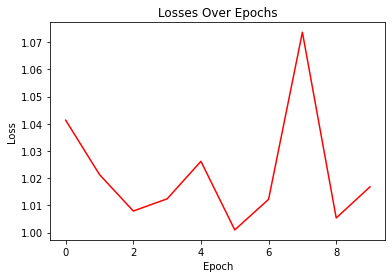

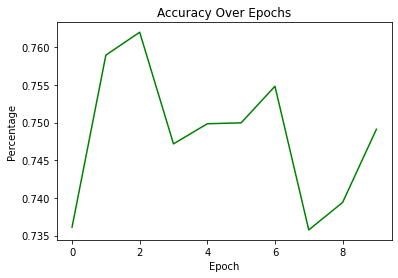

In [ ]:
import matplotlib.pyplot as plt

class Model(tf.keras.Model):
    def __init__(self, vocab_size):
        """
        The Model class predicts the next words in a sequence.

        :param vocab_size: The number of unique words in the data
        """

        super(Model, self).__init__()

        # Initialize hyperparameters
        self.vocab_size = num_words_final
        self.learning_rate = 0.01
        self.embedding_size = 150
        self.LSTM_size = 150
        self.batch_size = 100
        
        self.adam_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_size)
        self.lstm = tf.keras.layers.LSTM(self.LSTM_size)
        self.dense = tf.keras.layers.Dense(5, activation="softmax")
        self.dropout = tf.keras.layers.Dropout(0.3)

    def call(self, inputs):
        # implement call function
        input_words = self.embedding(inputs)
        lstm_out = self.lstm(input_words)
        out = self.dropout(lstm_out)
        outputs = self.dense(out)
        return outputs

    def loss(self, logits, labels):
        # calculate loss using Sparse Categorical Crossentropy
        labels = tf.reshape(labels, [-1,1])
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits)
        return loss

    def accuracy(self, logits, labels):
        # calculate accuracy based on percentage difference between predictions and actual prices
        correct = np.argmax(logits, axis=1) == labels
        accuracy = (np.sum(correct, axis=0) / len(labels))
        return accuracy 

def batch_data(array, index, batch_size):
	  # take in a batch size argument, index argument inputs, and labels
	  # call this in train and test
    return_array = array[index : (index+batch_size)]
    return return_array

def train(model, train_inputs, train_labels):  
  #shuffle the inputs and labels
  index = tf.range(len(train_labels))
  index = tf.random.shuffle(index)
  train_inputs = tf.gather(train_inputs, index)
  train_labels = tf.gather(train_labels, index)
  loss_list = []

  for n in range(int(len(train_labels)/ model.batch_size)):
      lbatch = batch_data(train_labels, n*model.batch_size, model.batch_size)
      ibatch = batch_data(train_inputs, n* model.batch_size, model.batch_size)
      with tf.GradientTape() as tape:
        predictions = model.call(ibatch)
        # Get the average loss per batch
        loss = model.loss(predictions,lbatch)
        loss_list.append(loss)
      gradients = tape.gradient(loss, model.trainable_variables)
      model.adam_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # Get final loss
  return tf.math.reduce_mean(loss_list)

def test(model, test_inputs, test_labels):
    test_inputs = tf.convert_to_tensor(test_inputs, dtype= tf.int32)
    test_labels = tf.convert_to_tensor(test_labels, dtype= tf.int32)
    test_logits = model.call(test_inputs)
    acc = model.accuracy(test_logits, test_labels)
    return acc

#used to visualize the loss per epoch
def visualize_loss(loss):
    x = np.arange(0, len(loss))
    y = loss
    plt.title("Losses Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(x, y, color ="red")
    plt.show()

#used to visualize accuracy per epoch
def visualize_accuracy(acc):
    x = np.arange(0, len(acc))
    y = acc
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Percentage")
    plt.plot(x, y, color ="green")
    plt.show()

def main():
    losseslist = []
    loss = np.inf
    ploss = 0
    converge = 0.0001
    count = 0
    accs = []
    train_labelsarray = np.asarray(our_trainlabels).astype(np.float32)
    test_labelsarray = np.asarray(our_testlabels).astype(np.float32)

    #determine when to stop based on the change in loss 
    while abs(ploss - loss) > converge:
        count += 1
        #maximum number of epochs is 10
        if count > 10:
            break
        model = Model(len(dict_set))
        ploss = loss
        loss= train(model, our_traininputs, train_labelsarray)
        acc = (test(model, our_testinputs, test_labelsarray))
        
        # uncomment to see epoch number, loss, accuracy
        print("epoch:", count)
        print("loss:", loss) 
        print("accuracy:", acc)

        #used for loss visualization
        losseslist.append(loss)

        #used for accuracy visualization
        accs.append(acc)

    #used for prediction vs actual sentiment graph
    graphpreds = model.call(our_testinputs)
    graphlabels = test_labelsarray 

    # #visualize graphs
    visualize_loss(losseslist)
    # visualize_difference(graphpreds, graphlabels)
    visualize_accuracy(accs)

if __name__ == '__main__':
	main()
 

# **Sentiment Analysis on Elon Musk Tweets Dataset Using Our Own Sentiment Analysis Model**

In [ ]:
# load the data
data = pd.read_csv('/content/gdrive/My Drive/DL_Final_Project/musktweets.csv')

# delete attributes that won't help learning
del data['conversation_id']
del data['created_at']
del data['timezone']
del data['place']
del data['language']
del data['hashtags']
del data['cashtags']
del data['user_id']
del data['user_id_str']
del data['username']
del data['name']
del data['day']
del data['hour']
del data['link']
del data['urls']
del data['photos']
del data['video']
del data['thumbnail']
del data['retweet']
del data['nlikes']
del data['nreplies']
del data['nretweets']
del data['quote_url']
del data['search']
del data['near']
del data['geo']
del data['source']
del data['user_rt_id']
del data['user_rt']
del data['retweet_id']
del data['reply_to']
del data['retweet_date']
del data['translate']
del data['trans_src']
del data['trans_dest']

# convert date to dateformat
data['date'] = pd.to_datetime(data['date'])

# only get tweets within a one year time period
data_oneyear = data[(data['date'] >= '2019-01-01') & (data['date'] <= '2021-01-01')]
data_oneyear

,Unnamed: 0,id,date,tweet
0,0,1343644462036086785,2020-12-28 19:46:18,Entertainment will be critical when cars drive...
1,1,1343619610617077760,2020-12-28 18:07:33,@kimpaquette Just meeting with Larry Ellison t...
2,2,1343608616960491521,2020-12-28 17:23:51,@richierichhhhh_ Absolutely
3,3,1343608530998153222,2020-12-28 17:23:31,What should Tesla do with in-car gaming in an ...
4,4,1343431408052662273,2020-12-28 05:39:42,@PPathole @WSJ Absolutely
...,...,...,...,...
6257,6257,1080636120159870976,2019-01-03 01:25:02,Great work by Tesla Team!
6258,6258,1080000130407776264,2019-01-01 07:17:51,Congratulations @Tesla team!! https://t.co/PB...
6259,6259,1079951408231665664,2019-01-01 04:04:14,@nichegamer Thanks!
6260,6260,1079922484445495296,2019-01-01 02:09:18,@IanReyTamayo Haha


In [ ]:
def cleantext(text):
    # Remove Hashtags Symbol
    text = re.sub(r"#", "", text) 
    #Remove the ! Symbol
    text = re.sub(r"!", "", text) 
    #Remove the , Symbol
    text = re.sub(r",", " ", text)
    #Remove a mention
    text = re.sub('@[^\s]+', '', text)
    #Remove link
    text = re.sub('https[^\s]+', '', text)
    #Remove numbers
    text = re.sub('[\d.]', '', text)
    return text

data_oneyear["tweet"] = data_oneyear["tweet"].apply(cleantext)
data_oneyear["tweet"] = data_oneyear["tweet"].str.lower()

data_oneyear["tweet"] = data_oneyear["tweet"].str.replace('.', '')
data_oneyear["tweet"] = data_oneyear["tweet"].str.replace('?', '')
data_oneyear["tweet"] = data_oneyear["tweet"].str.replace(':', '')
data_oneyear["tweet"] = data_oneyear["tweet"].str.replace('/(?:https?|ftp):\/\/[\n\S]+/g, ', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [ ]:
data_oneyear = data_oneyear.drop(data_oneyear.columns[0], axis =1)

In [ ]:
# get outputs
data_oneyear.to_excel (r'/content/gdrive/My Drive/DL_Final_Project/data_oneyear.xlsx', index = None, header = True)

In [ ]:
# create a dictionary that maps the tweet to the tweet id 
musk_dictionary = {i: [data_oneyear['id'][i], data_oneyear['date'][i],data_oneyear['tweet'][i]] for i in range(len(data_oneyear))}

# get the tweets that only have mentions to crytocurrencies
keys = []
for key, value in musk_dictionary.items():
  for word in value[2].split():
    if word == "bitcoin" or word == "bitcoins" or word == "dogecoin" or word == "doge" or word == "dogecoins" or word == "ethereum" or word == "ethereums" or word == "ether" or word == "eth" or word == "btc":
      keys.append(key)

# create a new dictionary with only tweets that have references to crytocurrencies
for key in list(musk_dictionary):
  if key not in keys:
    musk_dictionary.pop(key, None)

In [ ]:
tweet_dictionary = {}
i= 0
for key, value in musk_dictionary.items():
  tweet_dictionary[i] = value[2]
  i += 1

In [ ]:
all_sentences_array = []
for value in tweet_dictionary.values():
  all_sentences_array.append(value)

all_words_array = []
for sentence in all_sentences_array:
  for word in sentence.split():
    all_words_array.append(word)

In [ ]:
# create a dictionary 
musk_dict_set = set(all_words_array)
musk_id_dict = {}
for i, value in enumerate(musk_dict_set):
  for word in value.split():
    musk_id_dict[word] = i +1

# # read in and tokenize training data that matches each unique word in training data to a unique int
musk_tokenized_test_data = {}
for key, value in tweet_dictionary.items():
  new_array = []
  for word in value.split():
    new_array.append(musk_id_dict.get(word))
  musk_tokenized_test_data[key]= np.asarray(new_array, dtype = np.int32)

In [ ]:
musk_paddingtest = {}
for i,value in enumerate(all_sentences_array):
  musk_paddingtest[i] = np.zeros(25, np.int32)

## add padding to the left of the array
for key, value in musk_tokenized_test_data.items():
   # drop if the tweet doesn't contain any words 
  if len(value) == 0:
    musk_tokenized_test_data.pop(key, None)
  musk_paddingtest[key][-len(value):] = musk_tokenized_test_data[key][:len(value)]

In [ ]:
our_elonmusktestinputs = np.array(list(musk_paddingtest.values()))

**Run the Model**

In [ ]:
import matplotlib.pyplot as plt

class Model(tf.keras.Model):
    def __init__(self, vocab_size):
        """
        The Model class predicts the next words in a sequence.

        :param vocab_size: The number of unique words in the data
        """

        super(Model, self).__init__()

        # Initialize hyperparameters
        self.vocab_size = num_words_final
        self.learning_rate = 0.01
        self.embedding_size = 150
        self.LSTM_size = 150
        self.batch_size = 100
        
        self.adam_optimizer = tf.keras.optimizers.Adam(self.learning_rate)
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_size)
        self.lstm = tf.keras.layers.LSTM(self.LSTM_size)
        self.dense = tf.keras.layers.Dense(5, activation="softmax")
        self.dropout = tf.keras.layers.Dropout(0.3)

    def call(self, inputs):
        # pass inputs through all layers
        input_words = self.embedding(inputs)
        lstm_out = self.lstm(input_words)
        out = self.dropout(lstm_out)
        outputs = self.dense(out)
        return outputs

    def loss(self, logits, labels):
        # calculate loss using Sparse Categorical Crossentropy
        labels = tf.reshape(labels, [-1,1])
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits)
        return loss

def batch_data(array, index, batch_size):
	  # cake in a batch size argument, index argument inputs, and labels
	  # call this in train and test
    return_array = array[index : (index+batch_size)]
    return return_array

def train(model, train_inputs, train_labels):  
  #shuffle the inputs and labels
  index = tf.range(len(train_labels))
  index = tf.random.shuffle(index)
  train_inputs = tf.gather(train_inputs, index)
  train_labels = tf.gather(train_labels, index)
  loss_list = []

  for n in range(int(len(train_labels)/ model.batch_size)):
      lbatch = batch_data(train_labels, n*model.batch_size, model.batch_size)
      ibatch = batch_data(train_inputs, n* model.batch_size, model.batch_size)
      with tf.GradientTape() as tape:
        predictions = model.call(ibatch)
        # get the average loss per batch
        loss = model.loss(predictions,lbatch)
        loss_list.append(loss)
      gradients = tape.gradient(loss, model.trainable_variables)
      model.adam_optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  # get final loss
  return tf.math.reduce_mean(loss_list)

def test(model, test_inputs, test_labels):
    #test the model
    test_inputs = tf.convert_to_tensor(test_inputs, dtype= tf.int32)
    test_labels = tf.convert_to_tensor(test_labels, dtype= tf.int32)
    test_logits = model.call(test_inputs)
    return test_logits
  
def visualize_results(c, results_list):
  # get the results from the final epoch
  results = results_list[c]

  # put tweets and final classification in a dictionary
  tweets = []
  dates = []
  ids = []

  for key, value in musk_dictionary.items():
    tweets.append(musk_dictionary[key][2])
    dates.append(musk_dictionary[key][1])
    ids.append(musk_dictionary[key][0])

  results_dict = {i: [ids[i], dates[i], tweets[i], results[i]] for i in range(len(results))}

  df = pd.DataFrame(results_dict).transpose()
  df.columns =['Tweet_ID', 'Date', 'Tweet', 'Sentiment']
  df['Sentiment Interpretation'] = ''

  for i in range(len(df)):
    if df["Sentiment"][i] == 0:
      df["Sentiment Interpretation"][i] = "Extremely Negative"
    elif df["Sentiment"][i] == 1:
      df["Sentiment Interpretation"][i] = "Negative"
    elif df["Sentiment"][i] == 2:
      df["Sentiment Interpretation"][i] = "Neutral"
    elif df["Sentiment"][i] == 3:
      df["Sentiment Interpretation"][i] = "Positive"
    elif df["Sentiment"][i] == 4:
      df["Sentiment Interpretation"][i] = "Extremely Positive"

  # show final results 
  display(df)
  return df

def main():
    loss = np.inf
    ploss = 0
    converge = 0.0001
    count = 0
    class_list = []
    train_labelsarray = np.asarray(our_trainlabels).astype(np.float32)
    test_labelsarray = np.asarray(our_testlabels).astype(np.float32)

    #stop if change in loss is less than convergence threshold
    while abs(ploss - loss) > converge:
      count += 1
      # Maximum number of epochs is 10
      if count > 9:
        break
      model = Model(len(dict_set))
      ploss = loss
      loss= train(model, our_traininputs, train_labelsarray)
      results = test(model, our_elonmusktestinputs, test_labelsarray)
      final_classification = np.argmax(results, axis=1)
      final_classification = np.asarray(final_classification, np.int32)
      class_list.append(final_classification)

      # Uncomment to see number of epochs, 
      print("epoch:", count)
      print("loss:", loss) 
      print("results:", final_classification)

    # visualize the results of the final epoch in a dataframe  
    finalres = visualize_results((count-2), class_list)
    finalres 

    #export results to an Excel file
    finalres.to_excel (r'/content/gdrive/My Drive/DL_Final_Project/sentimentresultstwo.xlsx', index = None, header = True)
if __name__ == '__main__':
	main()
 

epoch: 1
loss: tf.Tensor(1.0968344, shape=(), dtype=float32)
results: [2 0 2 1 1 1 1 3 2 2 2 3 2 2 3 2 2 2 1]
epoch: 2
loss: tf.Tensor(1.0401878, shape=(), dtype=float32)
results: [2 0 2 2 1 3 1 3 2 2 2 3 2 2 3 2 2 1 0]
epoch: 3
loss: tf.Tensor(1.1834141, shape=(), dtype=float32)
results: [2 0 2 2 3 1 2 1 2 2 2 3 3 2 3 2 2 1 1]
epoch: 4
loss: tf.Tensor(0.9912011, shape=(), dtype=float32)
results: [2 1 2 2 1 4 1 3 2 2 2 4 2 2 3 2 1 2 0]
epoch: 5
loss: tf.Tensor(1.0018526, shape=(), dtype=float32)
results: [2 1 2 2 1 1 1 1 2 2 2 2 2 2 3 2 2 1 0]
epoch: 6
loss: tf.Tensor(1.0483421, shape=(), dtype=float32)
results: [2 2 2 2 1 0 1 3 2 2 2 3 2 2 3 2 2 2 1]
epoch: 7
loss: tf.Tensor(1.0291274, shape=(), dtype=float32)
results: [2 0 2 3 0 1 1 3 1 2 2 1 2 2 3 2 1 1 0]
epoch: 8
loss: tf.Tensor(1.0600661, shape=(), dtype=float32)
results: [2 0 1 1 1 3 1 1 1 2 1 3 2 2 3 2 1 2 1]
epoch: 9
loss: tf.Tensor(1.0225701, shape=(), dtype=float32)
results: [2 1 2 2 1 3 1 3 1 2 2 3 2 2 3 2 2 2 1]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Tweet_ID,Date,Tweet,Sentiment,Sentiment Interpretation
0,1340590280848908288,2020-12-20 09:30:04,one word doge,2,Neutral
1,1340588909974200321,2020-12-20 09:24:37,bitcoin is almost as bs as fiat money,1,Negative
2,1340573003579617280,2020-12-20 08:21:25,bitcoin is my safe word,2,Neutral
3,1328458535340949505,2020-11-16 22:02:51,🎶 toss a bitcoin to ur witcher 🎶,2,Neutral
4,1284290215561986048,2020-07-18 00:53:43,excuse me i only sell doge,1,Negative
5,1278730873999949824,2020-07-02 16:42:52,i’m not building anything on ethereum not ...,3,Positive
6,1261429085999296512,2020-05-15 22:51:44,i still only own bitcoins btw,1,Negative
7,1261416824459030529,2020-05-15 22:03:01,pretty much although massive currency issuan...,3,Positive
8,1256353943765921792,2020-05-01 22:44:56,how much for some anime bitcoin,1,Negative
9,1254039929333649409,2020-04-25 13:29:52,dogecoin mode,2,Neutral
